<a href="https://colab.research.google.com/github/sagarghosh2/CBTC/blob/main/CBTC_TIME_SERIES_FORECASTING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAME:-SAGAR GHOSH
# TASK 2- TIME SERIES FORECASTING

In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [4]:
data = pd.read_csv("/content/Alcohol_Sales.csv")

data=data.sort_values(by='DATE')

data.head()
data.columns=['DATE', 'SALES']
data.head()

,DATE,SALES
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [5]:
data['DATE'] = pd.to_datetime(data['DATE'], infer_datetime_format = True)
data = data.set_index('DATE')
data.head()

,SALES
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [81]:
data.shape

(588, 1)

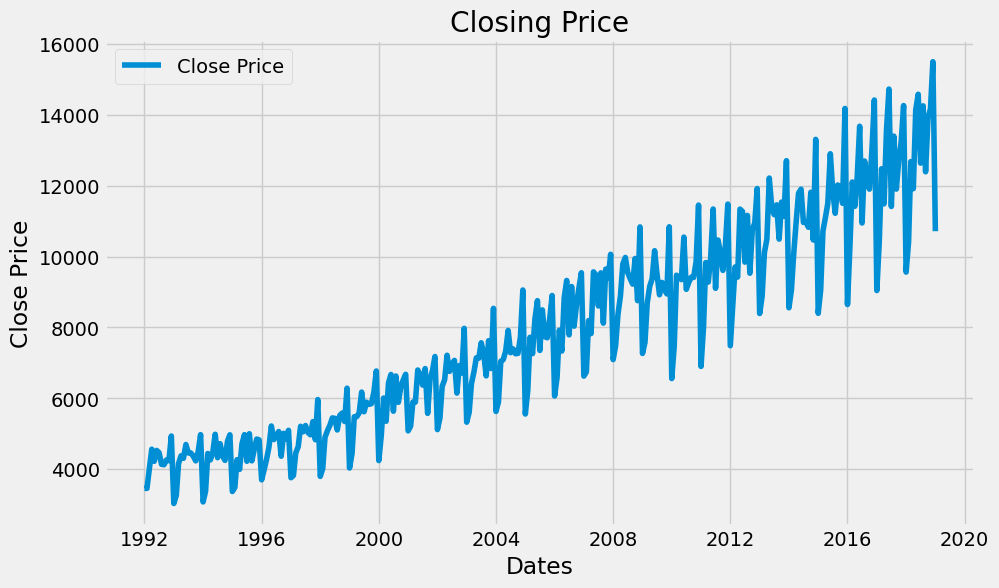

In [7]:
# Plot Close Price
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Price')
plt.plot(data['SALES'], label='Close Price')
plt.title('Closing Price')
plt.legend()
plt.show()


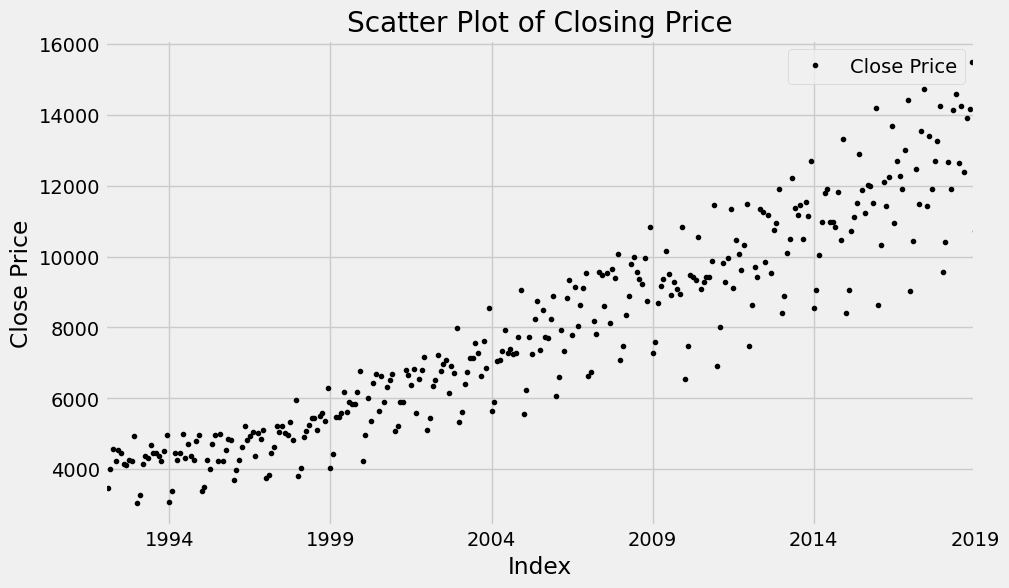

In [8]:
# Create scatter plot of closing price
df_alc = data['SALES']
plt.figure(figsize=(10, 6))
df_alc.plot(style='k.', label='Close Price')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Scatter Plot of Closing Price')
plt.legend()
plt.show()

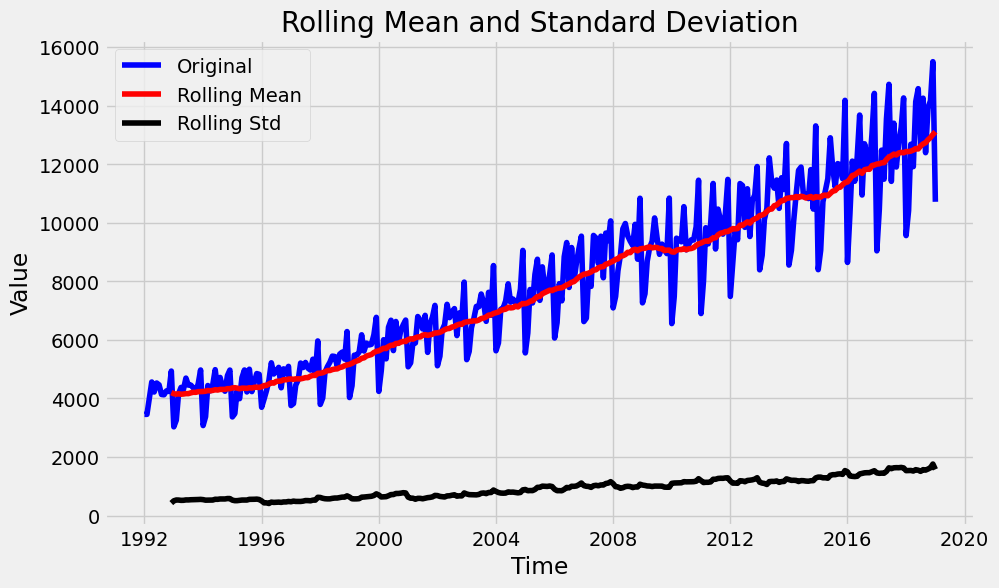

Results of Augmented Dickey-Fuller Test:
ADF Test Statistic: 2.037404725913695
p-value: 0.9987196267088919
# of lags used: 14
Number of observations used: 310

Weak evidence against the null hypothesis.
Fail to reject the null hypothesis.
Data has a unit root; it is non-stationary.

Critical Values:
Test Statistic                   2.037405
p-value                          0.998720
No. of lags used                14.000000
Number of observations used    310.000000
Critical Value (1%)             -3.451622
Critical Value (5%)             -2.870909
Critical Value (10%)            -2.571762
dtype: float64


In [10]:
# Test for stationarity
def test_stationarity(timeseries):
    # Determining rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    # Perform Augmented Dickey-Fuller test:
    print("Results of Augmented Dickey-Fuller Test:")
    adft = adfuller(timeseries, autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '# of lags used', 'Number of observations used']

    for value, label in zip(adft, labels):
        print(f"{label}: {value}")

    if adft[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis.")
        print("Reject the null hypothesis.")
        print("Data has no unit root and is stationary.")
    else:
        print("\nWeak evidence against the null hypothesis.")
        print("Fail to reject the null hypothesis.")
        print("Data has a unit root; it is non-stationary.")

    # Output for Dickey-Fuller test
    output = pd.Series(adft[0:4], index=['Test Statistic', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, value in adft[4].items():
        output[f'Critical Value ({key})'] = value

    print("\nCritical Values:")
    print(output)

# Assuming df_alc is defined earlier in your script
test_stationarity(df_alc)

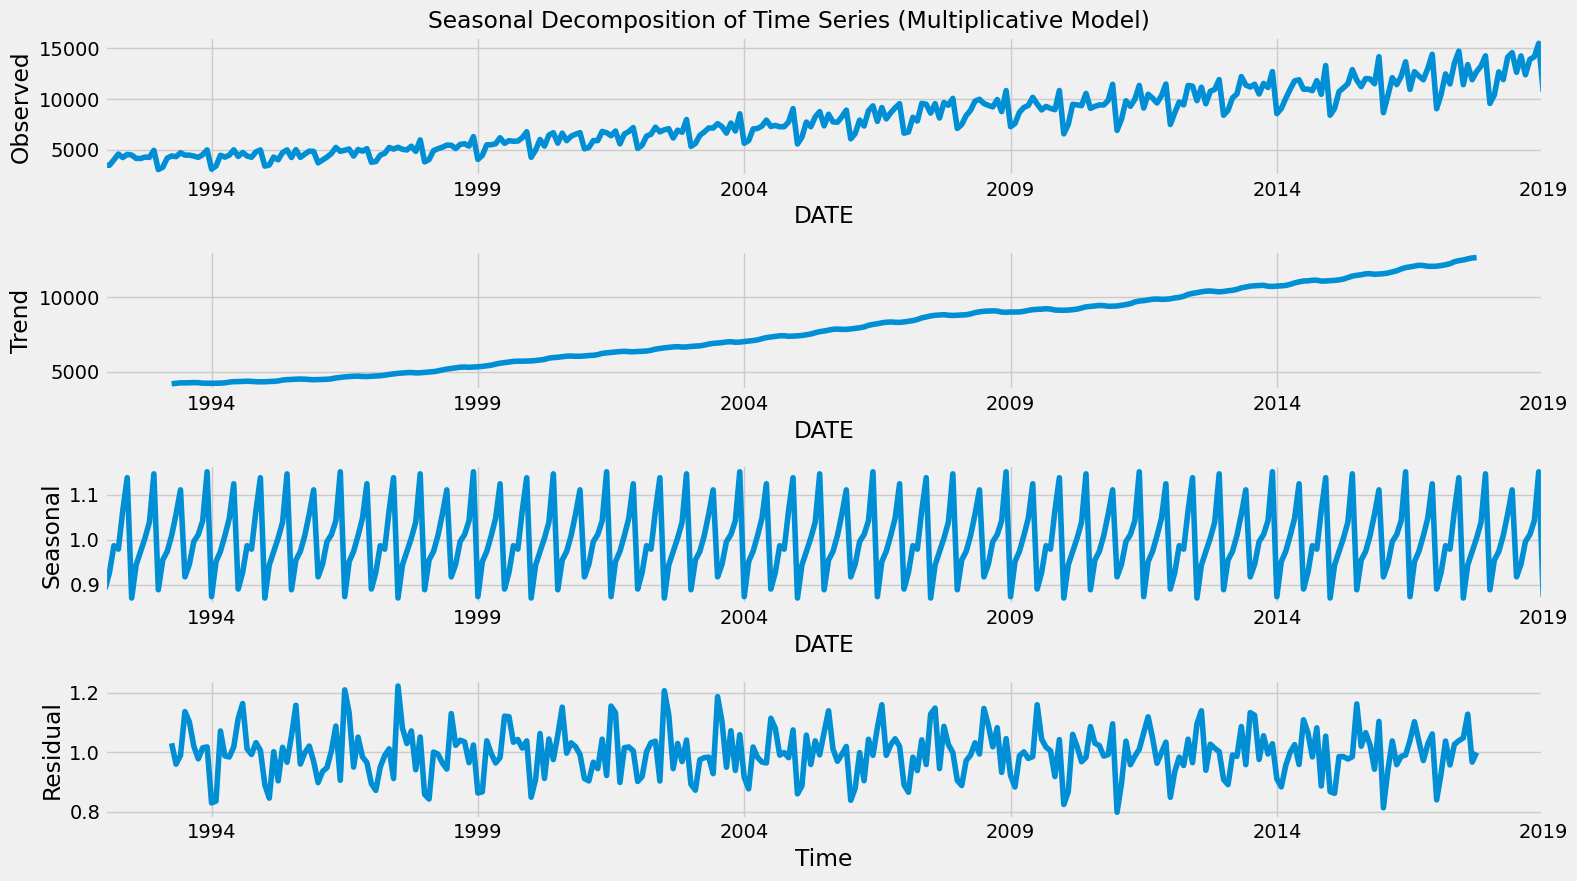

In [11]:
# Decompose the time series
result = seasonal_decompose(df_alc, model='multiplicative', period=30)

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))

result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
ax4.set_xlabel('Time')

plt.suptitle('Seasonal Decomposition of Time Series (Multiplicative Model)')
plt.tight_layout()
plt.subplots_adjust(top=0.95) # Adjust the top to fit the suptitle
plt.show()


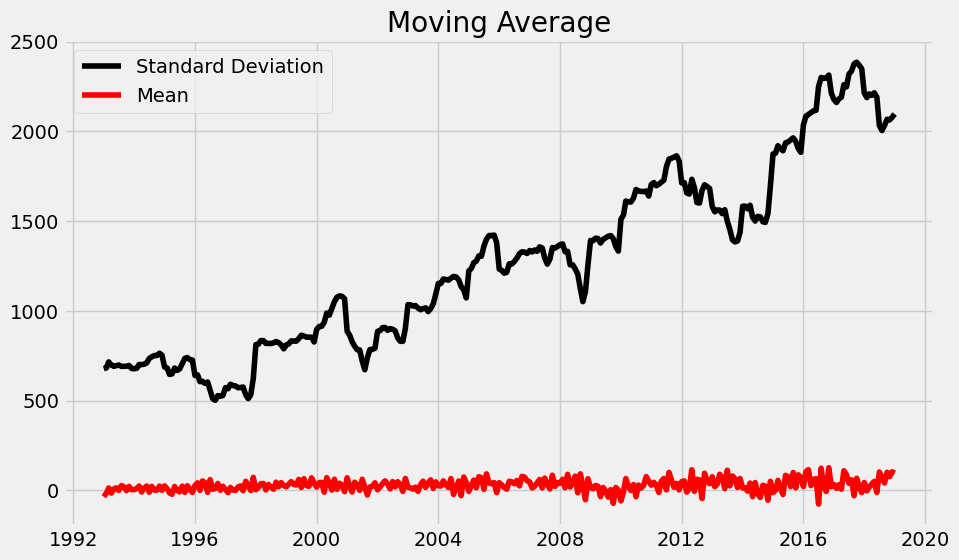

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
#df_log = np.log(df_close)
df_log = data['SALES'] - data['SALES'].shift(1)
df_log=df_log.dropna(axis=0)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

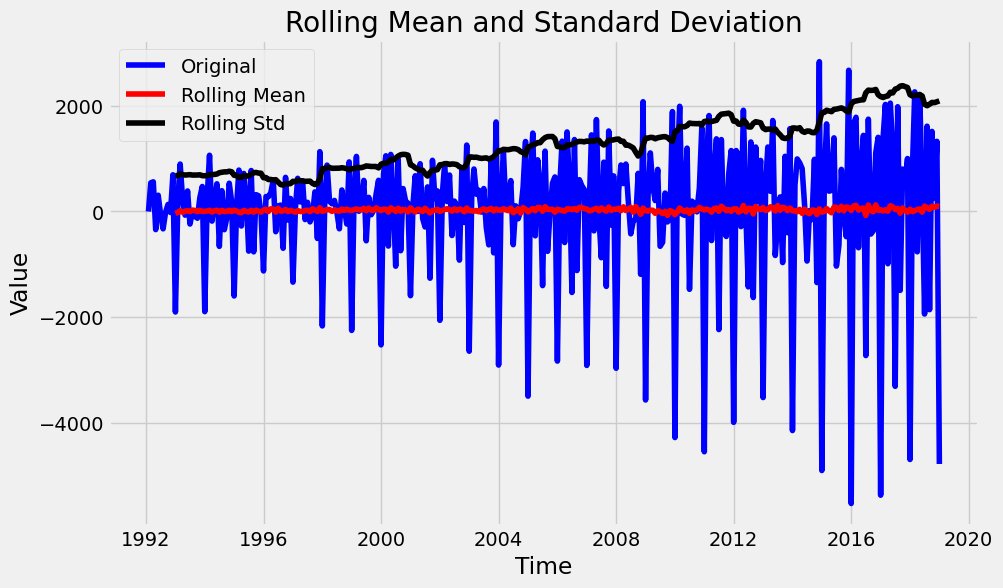

Results of Augmented Dickey-Fuller Test:
ADF Test Statistic: -4.36595961924603
p-value: 0.0003408284921170342
# of lags used: 13
Number of observations used: 310

Strong evidence against the null hypothesis.
Reject the null hypothesis.
Data has no unit root and is stationary.

Critical Values:
Test Statistic                  -4.365960
p-value                          0.000341
No. of lags used                13.000000
Number of observations used    310.000000
Critical Value (1%)             -3.451622
Critical Value (5%)             -2.870909
Critical Value (10%)            -2.571762
dtype: float64


In [13]:
test_stationarity(df_log)

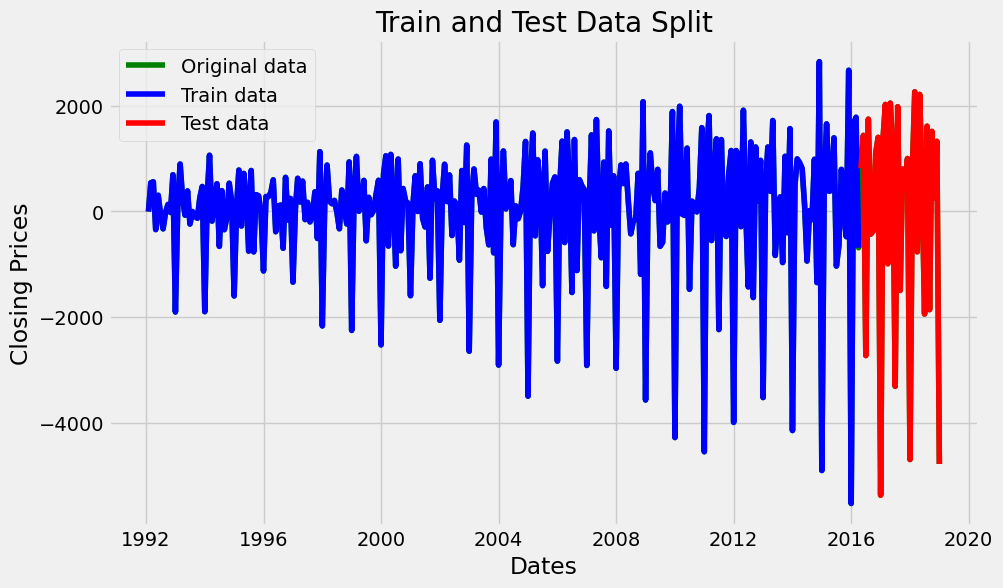

In [16]:
train_data = df_log.iloc[:int(len(df_log) * 0.9)]
test_data = df_log.iloc[int(len(df_log) * 0.9):]

# Plot the entire dataset, training data, and test data
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Original data')
plt.plot(train_data, 'blue', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()
plt.title('Train and Test Data Split')
plt.show()

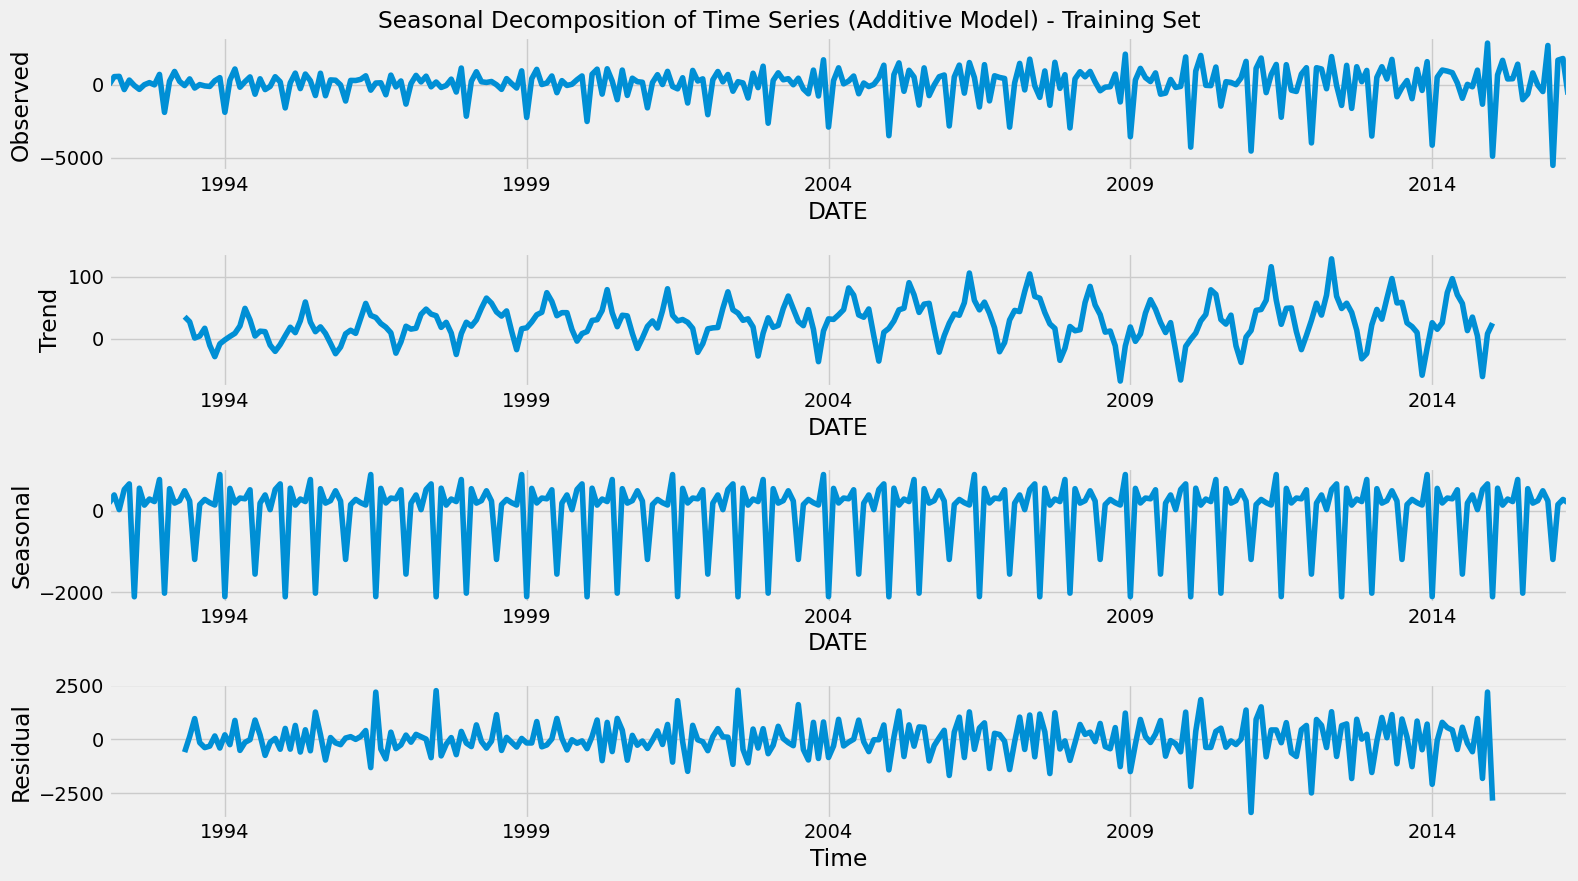

Training set size: 291
Test set size: 33


In [18]:
# Decompose the time series on the training set using the additive model
result = seasonal_decompose(train_data, model='additive', period=30)

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))

result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
ax4.set_xlabel('Time')

plt.suptitle('Seasonal Decomposition of Time Series (Additive Model) - Training Set')
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top to fit the suptitle
plt.show()

# Output the split data sizes for verification
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

In [19]:
train_data.shape

(291,)

In [20]:
test_data.shape

(33,)

In [22]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.3 MB/s eta 0:00:00


In [23]:
from pmdarima import auto_arima
# help(auto_arima) Get info on parameters

# Turn off warnings that can be distracting and of no concern
import warnings
warnings.filterwarnings('ignore')


# Trace shows the 1st couple ARIMA models it tried to fit
step_fit = auto_arima(train_data, m=12, trace=True)

# Returns AIC and BIC which estimate the quality of the models
# Then summary provides the best performing model
step_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=3991.559, Time=12.66 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4316.663, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4196.208, Time=0.80 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=4101.995, Time=1.68 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4314.669, Time=0.08 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=4004.520, Time=5.60 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=4012.965, Time=1.69 sec
 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=3978.383, Time=8.43 sec
 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=3999.018, Time=6.63 sec
 ARIMA(2,0,2)(2,1,2)[12] intercept   : AIC=3940.966, Time=12.74 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=3985.943, Time=9.55 sec
 ARIMA(1,0,2)(2,1,2)[12] intercept   : AIC=4007.469, Time=11.94 sec
 ARIMA(2,0,1)(2,1,2)[12] intercept   : AIC=3946.011, Time=10.50 sec
 ARIMA(3,0,2)(2,1,2)[12] intercept   : AIC=3945.501, Time=13.94 sec
 ARIMA(2,0,3)(

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  291
Model:             SARIMAX(4, 0, 4)x(2, 1, [1, 2], 12)   Log Likelihood               -1953.031
Date:                                 Fri, 02 Aug 2024   AIC                           3934.062
Time:                                         12:31:07   BIC                           3984.899
Sample:                                     02-01-1992   HQIC                          3954.455
                                          - 04-01-2016                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.0247     13.398      0.748      0.454     -16.234      36.284
ar.L1         -2.3568      0.191    -12.318      0.000      -2.732      -1.982
ar.L2         -2.6200      0.320     -8.189      0.000      -3.247      -1.993
ar.L3         -1.4698      0.308     -4.765      0.000      -2.074      -0.865
ar.L4         -0.2339      0.123     -1.904      0.057      -0.475       0.007
ma.L1          1.4240      0.168      8.472      0.000       1.095       1.753
ma.L2          0.6835      0.216      3.165      0.002       0.260       1.107
ma.L3         -0.4090      0.194     -2.112      0.035      -0.788      -0.029
ma.L4         -0.6294      0.127     -4.940      0.000      -0.879      -0.380
ar.S.L12       1.1365      0.278      4.089      0.000       0.592       1.681
ar.S.L24      -0.5551      0.141     -3.926      0.000      -0.832      -0.278
ma.S.L12      -1.5071      0.293     -5.150      0.000      -2.081      -0.933
ma.S.L24       0.7600      0.218      3.487      0.000       0.333       1.187
sigma2      9.472e+04   1.23e+04      7.730      0.000    7.07e+04    1.19e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.00
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               3.91   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

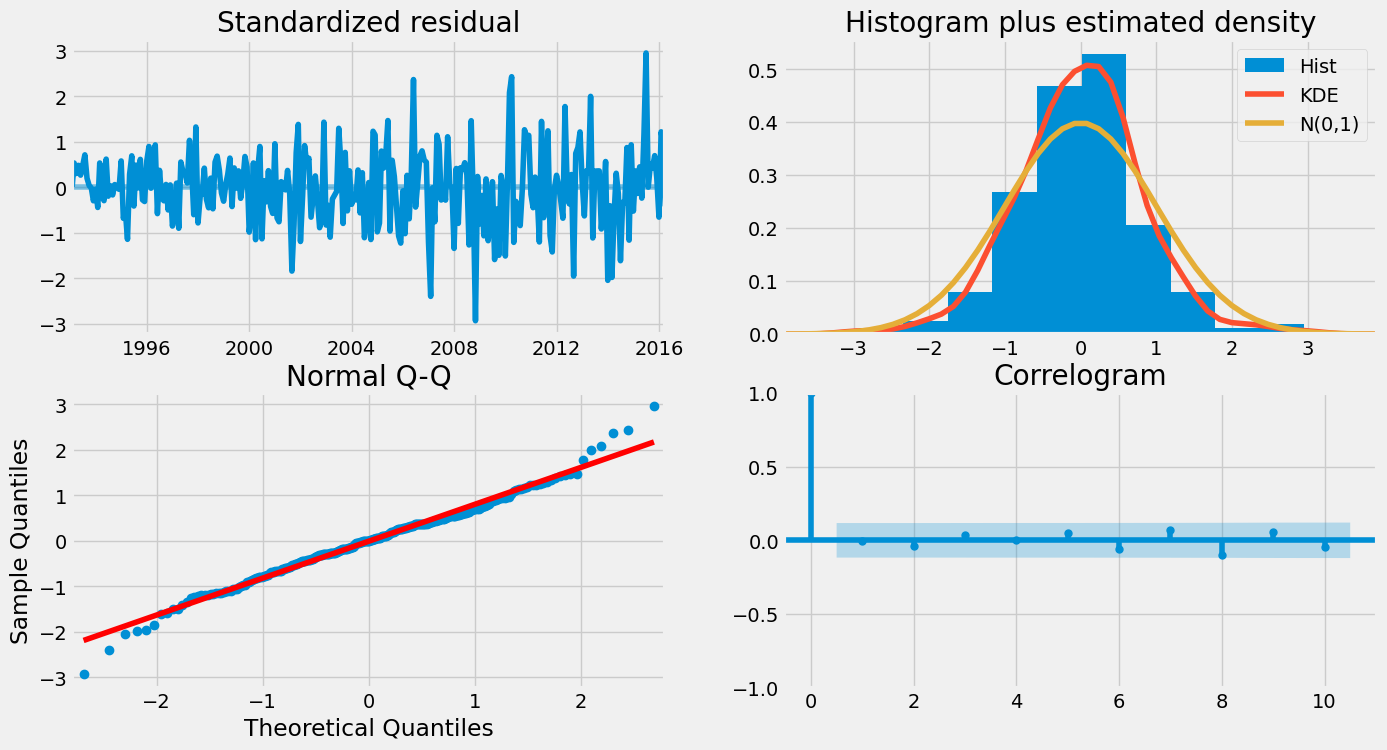

In [24]:
step_fit.plot_diagnostics(figsize=(15,8))
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  SALES   No. Observations:                  291
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -2347.273
Date:                Fri, 02 Aug 2024   AIC                           4714.545
Time:                        12:35:25   BIC                           4751.279
Sample:                    02-01-1992   HQIC                          4729.261
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.3260      8.298      3.293      0.001      11.063      43.589
ar.L1          0.1706      0.103      1.662      0.096      -0.031       0.372
ar.L2         -0.3082      0.096     -3.202      0.0

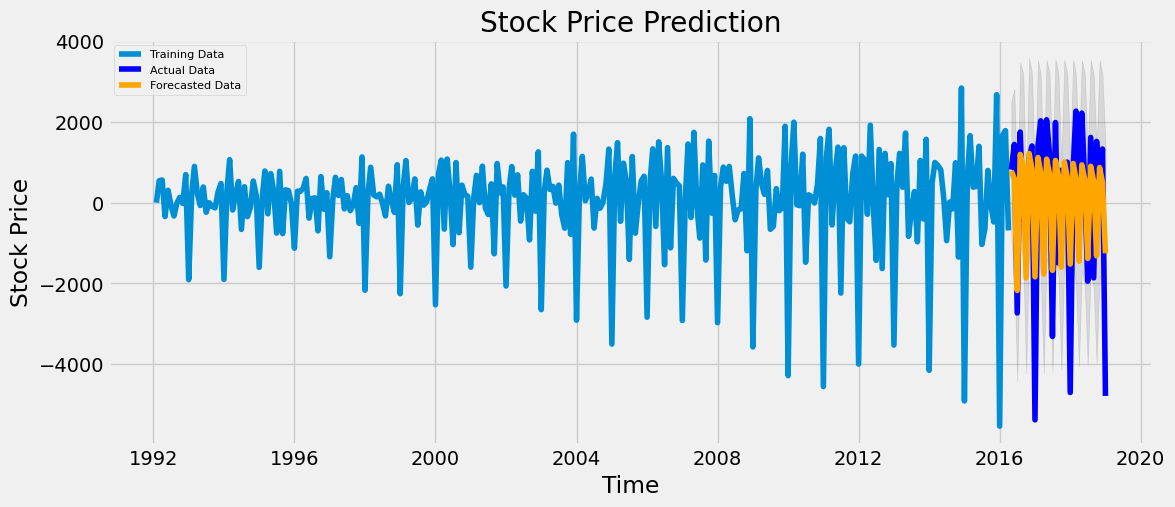

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Define and fit the ARIMA model
model = ARIMA(train_data, order=(4, 0, 4))
fitted = model.fit()
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(steps=len(test_data), alpha=0.05)  # Forecast length matches test_data
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot the results
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Data')
plt.plot(fc_series, color='orange', label='Forecasted Data')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.1)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [45]:
# Report performance
mse = mean_squared_error(test_data, fc)
print(f'MSE: {mse:.4f}')

mae = mean_absolute_error(test_data, fc)
print(f'MAE: {mae:.4f}')

rmse = math.sqrt(mse)
print(f'RMSE: {rmse:.4f}')

mape = np.mean(np.abs((fc - test_data) / test_data)) * 100
print(f'MAPE: {mape:.2f}%')

MSE: 2403131.0055
MAE: 1192.7207
RMSE: 1550.2035
MAPE: 89.39%


In [49]:
!pip install prophet

In [51]:
import pandas as pd
import numpy as np
from prophet import Prophet
%matplotlib inline
import os

In [52]:
df = pd.read_csv('/content/Miles_Traveled.csv')

In [53]:
df.head()

,DATE,TRFVOLUSM227NFWA
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              588 non-null    object 
 1   TRFVOLUSM227NFWA  588 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.3+ KB


In [55]:
# Renaming the columns of dataframe as per the convention of Prophet library
df.columns = ['ds', 'y']
df.head()

,ds,y
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


In [56]:
# Conveting the type of ds column to datetime format
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,ds,y
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


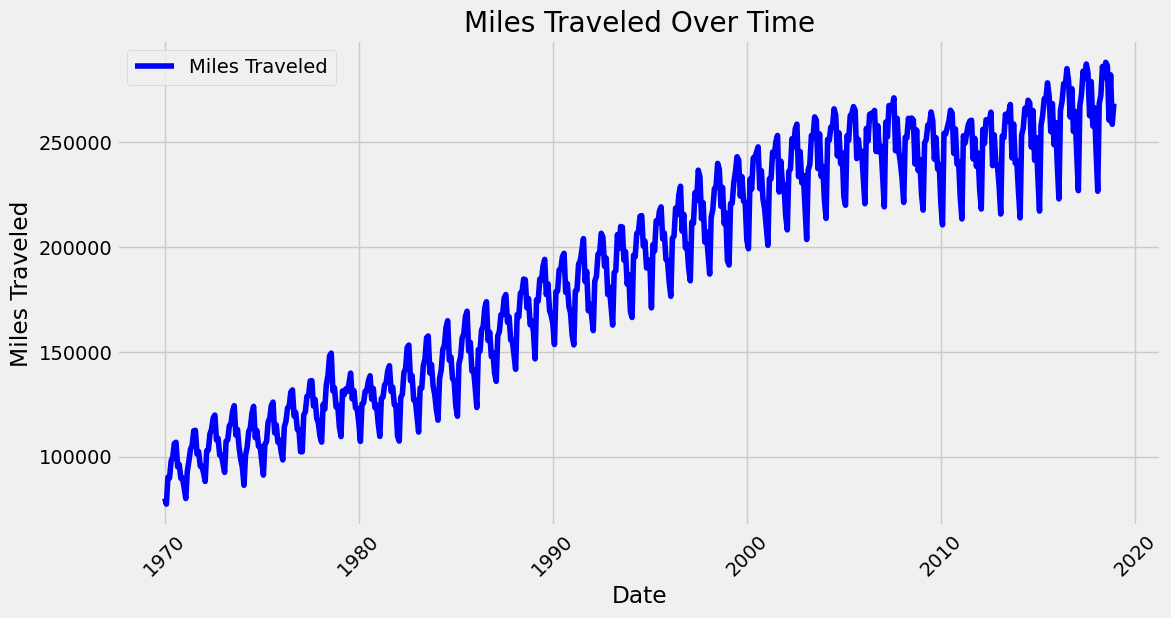

In [57]:
# Plot the actual behavior of the dataset
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Miles Traveled', color='blue')
plt.xlabel('Date')
plt.ylabel('Miles Traveled')
plt.title('Miles Traveled Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.show()

In [58]:
# Finding the number of rows in the dataset
num_rows = df.shape[0]
print(f'Number of rows in the dataset: {num_rows}')


Number of rows in the dataset: 588


In [59]:
# Determine the number of rows for the test set (12 months)
test_size = 12

# Split the dataset into train and test
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]

# Print the sizes of train and test sets
print(f'Number of rows in the training set: {len(train)}')
print(f'Number of rows in the test set: {len(test)}')


Number of rows in the training set: 576
Number of rows in the test set: 12


In [61]:
# Fit the Prophet model on the training data
m = Prophet()

# Fit the training data
m.fit(train)

# Create a future DataFrame
future = m.make_future_dataframe(periods=12, freq='MS')  # Forecast 12 months into the future

# Make predictions
forecast = m.predict(future)

# Display the forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()  # Show the last few rows of the forecast


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk782t4vw/6zn0krzl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk782t4vw/wol0lnw5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82741', 'data', 'file=/tmp/tmpk782t4vw/6zn0krzl.json', 'init=/tmp/tmpk782t4vw/wol0lnw5.json', 'output', 'file=/tmp/tmpk782t4vw/prophet_modelqufqugx8/prophet_model-20240802134554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:45:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:45:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
583,2018-08-01,279822.525528,274112.316228,285400.674033
584,2018-09-01,261845.428781,256343.018173,267448.009489
585,2018-10-01,268950.446795,263481.216817,274402.232563
586,2018-11-01,255577.144268,249755.746771,261238.283214
587,2018-12-01,257008.776083,251405.129101,262442.777021


In [62]:
forecast.shape

(588, 16)

In [63]:
forecast.iloc[-12:,]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
576,2018-01-01,262428.679272,237585.940873,249478.584030,262428.679272,262428.679272,-18616.744646,-18616.744646,-18616.744646,-18616.744646,-18616.744646,-18616.744646,0.0,0.0,0.0,243811.934625
577,2018-02-01,262569.983537,229859.010170,241038.516676,262569.983537,262569.983537,-27140.651561,-27140.651561,-27140.651561,-27140.651561,-27140.651561,-27140.651561,0.0,0.0,0.0,235429.331975
578,2018-03-01,262697.613195,256704.556133,268177.158502,262697.613195,262697.613195,-67.245170,-67.245170,-67.245170,-67.245170,-67.245170,-67.245170,0.0,0.0,0.0,262630.368025
579,2018-04-01,262838.917460,256750.883119,268612.523028,262838.917460,262838.917460,5.448626,5.448626,5.448626,5.448626,5.448626,5.448626,0.0,0.0,0.0,262844.366086
580,2018-05-01,262975.663523,266778.918310,278325.134621,262973.648390,262975.663523,9602.276786,9602.276786,9602.276786,9602.276786,9602.276786,9602.276786,0.0,0.0,0.0,272577.940309
581,2018-06-01,263116.967788,267191.744302,279121.267525,263103.387282,263119.309576,9712.369416,9712.369416,9712.369416,9712.369416,9712.369416,9712.369416,0.0,0.0,0.0,272829.337204
582,2018-07-01,263253.713851,273464.417951,284950.012764,263218.855009,263274.444553,16033.382453,16033.382453,16033.382453,16033.382453,16033.382453,16033.382453,0.0,0.0,0.0,279287.096304
583,2018-08-01,263395.018116,274112.316228,285400.674033,263326.976124,263433.893760,16427.507412,16427.507412,16427.507412,16427.507412,16427.507412,16427.507412,0.0,0.0,0.0,279822.525528
584,2018-09-01,263536.322381,256343.018173,267448.009489,263435.076736,263599.611633,-1690.893599,-1690.893599,-1690.893599,-1690.893599,-1690.893599,-1690.893599,0.0,0.0,0.0,261845.428781
585,2018-10-01,263673.068444,263481.216817,274402.232563,263534.493530,263774.951757,5277.378352,5277.378352,5277.378352,5277.378352,5277.378352,5277.378352,0.0,0.0,0.0,268950.446795


In [64]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
583,2018-08-01,263395.018116,274112.316228,285400.674033,263326.976124,263433.893760,16427.507412,16427.507412,16427.507412,16427.507412,16427.507412,16427.507412,0.0,0.0,0.0,279822.525528
584,2018-09-01,263536.322381,256343.018173,267448.009489,263435.076736,263599.611633,-1690.893599,-1690.893599,-1690.893599,-1690.893599,-1690.893599,-1690.893599,0.0,0.0,0.0,261845.428781
585,2018-10-01,263673.068444,263481.216817,274402.232563,263534.493530,263774.951757,5277.378352,5277.378352,5277.378352,5277.378352,5277.378352,5277.378352,0.0,0.0,0.0,268950.446795
586,2018-11-01,263814.372709,249755.746771,261238.283214,263638.599452,263952.819003,-8237.228440,-8237.228440,-8237.228440,-8237.228440,-8237.228440,-8237.228440,0.0,0.0,0.0,255577.144268
587,2018-12-01,263951.118771,251405.129101,262442.777021,263735.396680,264119.231921,-6942.342688,-6942.342688,-6942.342688,-6942.342688,-6942.342688,-6942.342688,0.0,0.0,0.0,257008.776083


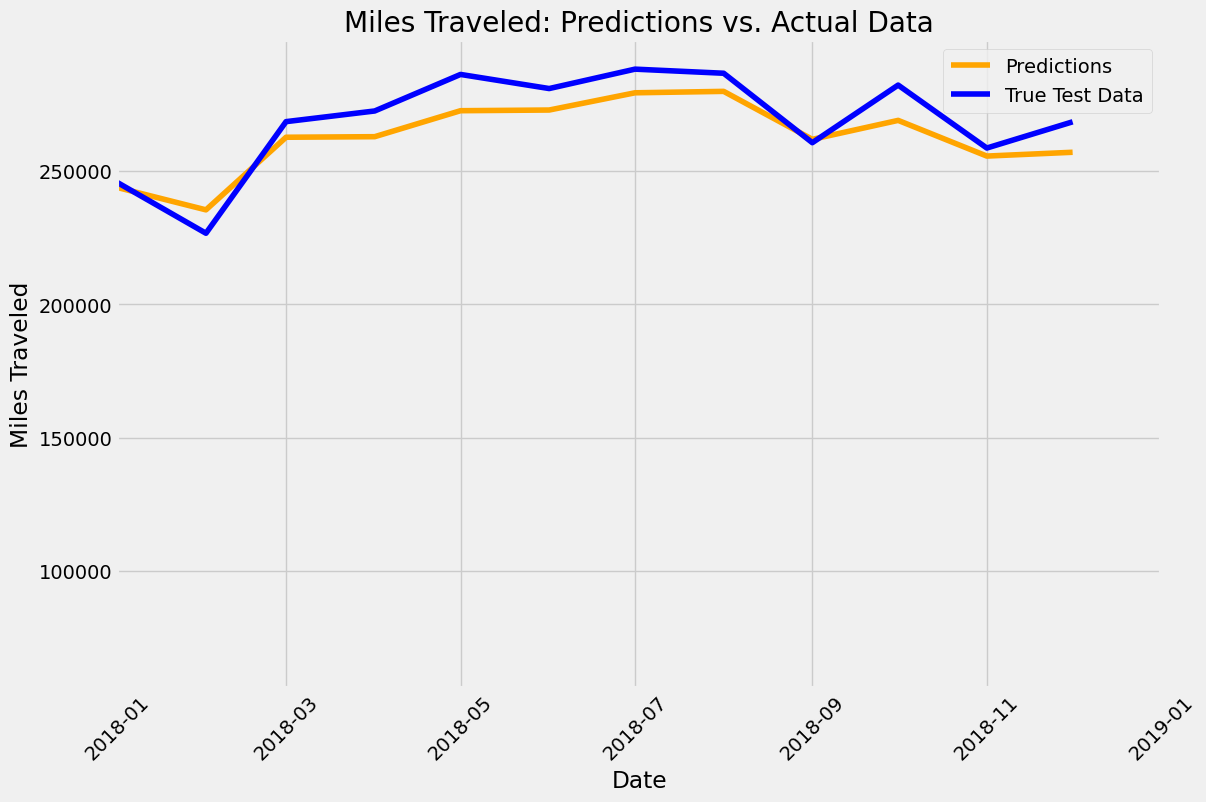

In [65]:
# Plotting the predicted values and the original test data
plt.figure(figsize=(12, 8))

# Plot the forecasted values
plt.plot(forecast['ds'], forecast['yhat'], label='Predictions', color='orange')

# Plot the true test data
plt.plot(test['ds'], test['y'], label='True Test Data', color='blue')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Miles Traveled')
plt.title('Miles Traveled: Predictions vs. Actual Data')
plt.legend()

# Set x-axis limits to focus on the test period
plt.xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2019-01-01'))

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)
plt.show()

In [66]:
from statsmodels.tools.eval_measures import rmse

# Extract the last 12 predictions from the forecast DataFrame
predictions = forecast.iloc[-12:]['yhat']

# Display the predictions
print("Predictions for the last 12 periods:")
print(predictions)


Predictions for the last 12 periods:
576    243811.934625
577    235429.331975
578    262630.368025
579    262844.366086
580    272577.940309
581    272829.337204
582    279287.096304
583    279822.525528
584    261845.428781
585    268950.446795
586    255577.144268
587    257008.776083
Name: yhat, dtype: float64


In [67]:
test['y']

,y
576,245695.0
577,226660.0
578,268480.0
579,272475.0
580,286164.0
581,280877.0
582,288145.0
583,286608.0
584,260595.0
585,282174.0


In [79]:
# Calculating rmse values
rmse(predictions, test['y'])

8644.964780756163

In [80]:
test.mean()

,0
ds,2018-06-16 12:00:00
y,268739.666667


In [70]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [71]:
# Initial training period (e.g., 5 years)
initial = 5 * 365
initial = f'{initial} days'  # Format as 'days' for Prophet

# Period length for cross-validation (e.g., 5 years)
period = 5 * 365
period = f'{period} days'  # Format as 'days' for Prophet

# Horizon of prediction for each fold (e.g., 1 year)
horizon = 365
horizon = f'{horizon} days'  # Format as 'days' for Prophet

# Print to verify
print(f'Initial training period: {initial}')
print(f'Period length for cross-validation: {period}')
print(f'Horizon of prediction: {horizon}')

Initial training period: 1825 days
Period length for cross-validation: 1825 days
Horizon of prediction: 365 days


In [72]:
df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon)

INFO:prophet:Making 9 forecasts with cutoffs between 1976-12-11 00:00:00 and 2016-12-01 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpk782t4vw/3lq8k3it.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk782t4vw/i3ybkh5u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30755', 'data', 'file=/tmp/tmpk782t4vw/3lq8k3it.json', 'init=/tmp/tmpk782t4vw/i3ybkh5u.json', 'output', 'file=/tmp/tmpk782t4vw/prophet_modelbx_za5mx/prophet_model-20240802135255.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:52:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:52:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk782t4vw/wapam17k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk782t4vw/1vvy5vcp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

In [73]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1977-01-01,108479.057830,107098.803827,109824.164845,102445.0,1976-12-11
1,1977-02-01,102996.081749,101584.147996,104428.929970,102416.0,1976-12-11
2,1977-03-01,118973.288965,117639.315756,120445.212485,119960.0,1976-12-11
3,1977-04-01,120612.897995,119170.912040,122062.104349,121513.0,1976-12-11
4,1977-05-01,127882.998497,126349.412354,129362.700478,128884.0,1976-12-11


In [74]:
len(df_cv)

108

In [75]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,52 days,2.441324e+07,4940.975365,4536.769797,0.027759,0.023487,0.027342,0.4
1,53 days,2.188610e+07,4678.257776,4267.106978,0.024974,0.023487,0.024677,0.4
2,54 days,1.848183e+07,4299.049320,3742.820236,0.020087,0.022326,0.019929,0.5
3,55 days,2.347725e+07,4845.333289,4273.621558,0.023215,0.023487,0.022964,0.4
4,57 days,2.126214e+07,4611.089262,4007.280855,0.021476,0.022326,0.021267,0.5
...,...,...,...,...,...,...,...,...
94,360 days,1.862537e+07,4315.712291,3779.654921,0.019714,0.019536,0.019723,0.5
95,361 days,1.774786e+07,4212.820863,3504.532878,0.018340,0.018934,0.018359,0.5
96,362 days,3.212707e+07,5668.074808,4432.588796,0.022148,0.024784,0.022047,0.4
97,364 days,3.034421e+07,5508.557637,4266.522128,0.021527,0.021703,0.021440,0.5


In [76]:
df.head(2)

,ds,y
0,1970-01-01,80173.0
1,1970-02-01,77442.0


In [77]:
df.tail(2)

,ds,y
586,2018-11-01,258590.0
587,2018-12-01,268413.0


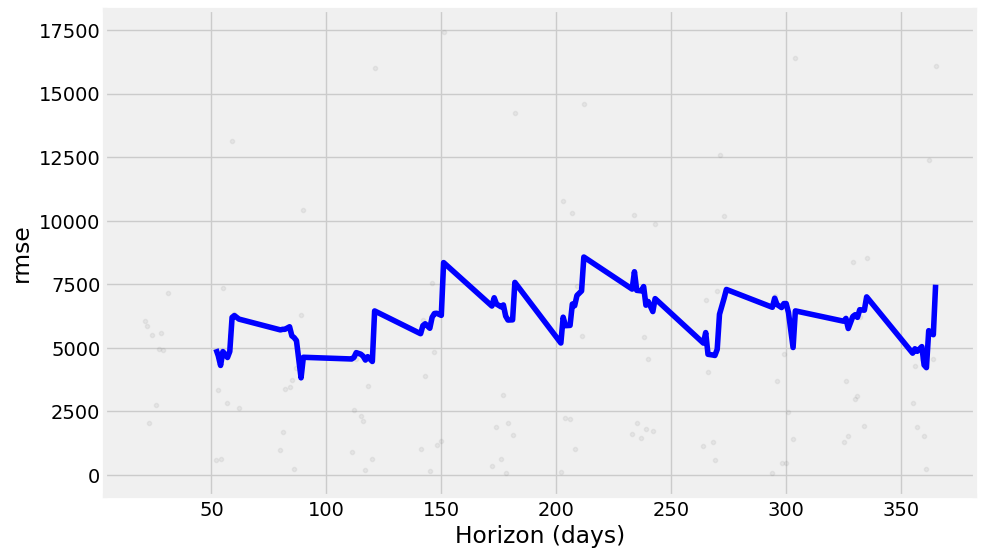

In [78]:
plot_cross_validation_metric(df_cv, metric='rmse');